# Ensemble NMS - Detectron2 [Inference]

# Introduction
This notebook deals with applying Non Max Suppression (NMS) - a technique used for ensembling the bounding box results obtained from Mask-R-CNN.

## Install and import libraries

The next few code cells install detectron libraries, pycocotools and a python module called ensemble-boxes-104 which contains the code for NMS.

In [1]:
!pip install ../input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019 --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/antlr4-python3-runtime-4.8/antlr4-python3-runtime-4.8 --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/detectron2-0.5/detectron2 --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/ensemble-boxes-104/ensemble_boxes-1.0.4/ -f ./ --no-index

Looking in links: ../input/detectron-05/whls
Processing /kaggle/input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272234 sha256=cb196cd549fd0b3be6f823300b7674e3f24ba829df0c96e7376e955e8366c955
  Stored in directory: /root/.cache/pip/wheels/d2/09/29/2054c6cc4599cf39f1c52ce3c20bfb50be696caa5d5ba460c9
Successfully built pycocotools
Looking in links: ../input/detectron-05/whls
Processing /kaggle/input/detectron-05/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
Processing /kaggle/in

In [2]:
import os
import cv2
import json
import time
import numpy as np
import pandas as pd
import torch
import detectron2
from tqdm.auto import tqdm
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import inference_on_dataset
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.data import DatasetCatalog, build_detection_test_loader
import pycocotools.mask as mask_util
from PIL import Image
import matplotlib.pyplot as plt
from fastcore.all import *
from ensemble_boxes import *


os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## My Models

Below, we create a dictionary variable with the file name, config files and class-wise thresholds. This will be used later in the notebook.

In [3]:
best_models_config = [{'file': 'model_best_fold_1.pth',
              'config_name': 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'
              , 'thresh': [.15, .35, .55]},
              {'file': 'model_best_fold_2.pth',
              'config_name': 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'
              , 'thresh': [.15, .35, .55]},
              {'file': 'model_best_fold_3.pth',
              'config_name': 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'
              , 'thresh': [.15, .35, .55]},
              {'file': 'model_best_fold_4.pth',
              'config_name': 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'
              , 'thresh': [.15, .35, .55]},
              {'file': 'model_best_fold_5.pth',
              'config_name': 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'
              , 'thresh': [.15, .35, .55]}]

Defining IoU threshold for NMS and minimum number of pixels required for a mask to be valid below:

In [4]:
model_path = Path("../input/livecellweights")
data_path = Path("../input/sartorius-cell-instance-segmentation")
models = []
best_models =[]
thresholds = []
test_path = data_path/'test'
MIN_PIXELS = [75, 150, 75]
IOU_TH = .4

Now, we generate a for loop wherein we append an empty list of models with individual models from each of the 5 folds.

In [5]:
for best_model in best_models_config:
    model_name = best_model["file"]
    model_ths = best_model["thresh"]
    config_name = best_model["config_name"]
    best_models.append(model_name)
    thresholds.append(model_ths)
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(config_name))
    cfg.INPUT.MASK_FORMAT = 'bitmask'
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
    cfg.MODEL.WEIGHTS = f'{model_path}/{model_name}'  
    cfg.TEST.DETECTIONS_PER_IMAGE = 1000
    
    models.append(DefaultPredictor(cfg))

## Utils

The functions written below are used to generate inferences.

In [6]:
def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) 
                       for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def pred_masks(file_name, path, model, ths, min_pixels):
    image = cv2.imread(str(path/file_name))
    output = model(image)
    pred_classes = output['instances'].pred_classes.cpu().numpy().tolist()
    pred_class = max(set(pred_classes), key=pred_classes.count)
    take = output['instances'].scores >= ths[pred_class]
    pred_masks = output['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    result = []
    used = np.zeros(image.shape[:2], dtype=int) 
    for i, mask in enumerate(pred_masks):
        mask = mask * (1 - used)
        if mask.sum() >= min_pixels[pred_class]:
            used += mask
            result.append(rle_encode(mask))
    return result

def predict_models(file_name, path, models, thresholds):
    image = cv2.imread(str(path/file_name))
    classes, scores, bboxes, masks = [], [], [], []
    for i, model in enumerate(models):
        output = model(image)
        pred_classes = output['instances'].pred_classes.cpu().numpy().tolist()
        pred_class = max(set(pred_classes), key=pred_classes.count)
        score_thresh_mask = output['instances'].scores >= thresholds[i][pred_class]
        classes.extend(output['instances'].pred_classes[score_thresh_mask].cpu().numpy().tolist())
        scores.extend(output['instances'].scores[score_thresh_mask].cpu().numpy().tolist())
        bboxes.extend(output['instances'].pred_boxes[score_thresh_mask].tensor.cpu().numpy().tolist())
        masks.extend(output['instances'].pred_masks[score_thresh_mask].cpu().numpy())
    return classes, scores, bboxes, masks

def nms_predictions(classes, scores, bboxes, masks, 
                    iou_th=0.4, shape=(520, 704)):
    he, wd = shape[0], shape[1]
    boxes_list = [[x[0] / wd, x[1] / he, x[2] / wd, x[3] / he]
                  for x in bboxes]
    scores_list = [x for x in scores]
    labels_list = [x for x in classes]
    nms_bboxes, nms_scores, nms_classes = nms(
        boxes=[boxes_list], 
        scores=[scores_list], 
        labels=[labels_list], 
        weights=None,
        iou_thr=iou_th
    )
    nms_masks = []
    for s in nms_scores:
        nms_masks.append(masks[scores.index(s)])
    nms_scores, nms_classes, nms_masks = zip(*sorted(zip(nms_scores, nms_classes, nms_masks), reverse=True))
    return nms_classes, nms_scores, nms_masks

def clean_masks(masks, classes, min_pixels, shape=(520, 704)):
    result = []
    pred_class = max(set(classes), key=classes.count)
    used = np.zeros(shape, dtype=int) 
    for i, mask in enumerate(masks):
        mask = mask * (1 - used)
        if mask.sum() >= min_pixels[pred_class]:
            used += mask
            result.append(rle_encode(mask))
    return result

def ensemble_all(test_name, test_path, models, thresholds):
    classes, scores, bboxes, masks = predict_models(
        file_name=test_name, 
        path=test_path, 
        models=models, 
        thresholds=thresholds
    )
    classes, scores, masks = nms_predictions(
        classes, 
        scores, 
        bboxes, 
        masks
    )
    encoded_masks = clean_masks(
        masks, 
        classes, 
        min_pixels=MIN_PIXELS
    )
    return encoded_masks

## Demo inference

In this section, we test out the NMS inference and visualize the difference between a single model and an ensembled NMS model.

In [7]:
test_names = os.listdir(test_path)
print('test images:', len(test_names))

test images: 3


In [8]:
test_id = 0

encoded_masks_single = pred_masks(
    test_names[test_id], 
    path=test_path, 
    model=models[0],
    ths=thresholds[0],
    min_pixels=MIN_PIXELS
)


encoded_masks = ensemble_all(test_names[test_id], test_path, models, thresholds)

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


Now that the encoded mask for a sample file has been generated, we proceed to visualize the ensembled masks before generating prediction masks for all of the test images.

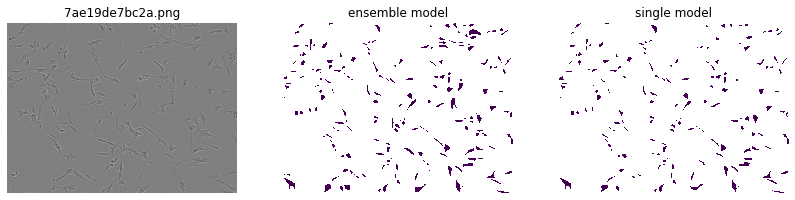

In [9]:
_, axs = plt.subplots(1, 3, figsize=(14, 8))


axs[0].imshow(cv2.imread(f'{test_path}/{test_names[test_id]}'))
axs[0].axis('off')
axs[0].set_title(test_names[test_id])

for en_mask in encoded_masks:
    dec_mask = rle_decode(en_mask)
    axs[1].imshow(np.ma.masked_where(dec_mask == 0, dec_mask))
    axs[1].axis('off')
    axs[1].set_title('ensemble model')


for en_mask in encoded_masks_single:
    dec_mask = rle_decode(en_mask)
    axs[2].imshow(np.ma.masked_where(dec_mask == 0, dec_mask))
    axs[2].axis('off')
    axs[2].set_title('single model')

plt.show()

## Inference

In this section, we generate prediction masks for all of the test images and create a submission file for submission to the Kaggle competition.

In [10]:
submission_ids, submission_masks = [], []
for test_name in tqdm(test_names):
    
    encoded_masks = ensemble_all(test_name, test_path, models, thresholds)

    for enc_mask in encoded_masks:
        submission_ids.append(test_name[:test_name.find('.')])
        submission_masks.append(enc_mask)

  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
pd.DataFrame({
    'id': submission_ids, 
    'predicted': submission_masks
}).to_csv('submission.csv', index=False)
pd.read_csv('submission.csv').head()

,id,predicted
0,7ae19de7bc2a,140003 18 140706 22 141410 22 142114 22 142818...
1,7ae19de7bc2a,139541 5 140244 7 140948 8 141652 8 142356 9 1...
2,7ae19de7bc2a,25933 2 26626 16 27328 18 28031 19 28733 21 29...
3,7ae19de7bc2a,146708 6 147412 9 148116 12 148820 13 149524 1...
4,7ae19de7bc2a,96418 4 97121 6 97825 7 98529 8 99233 9 99937 ...
